<a href="https://colab.research.google.com/github/IamShivamJaiswal/object_train_tensorflow_colab/blob/master/object_custom_tf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in July 13 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#july-13-2018).

**Colab Runtime type: Python2, GPU enabled.**



#Create Dataset

I generated dataset annotations with [LabelImg](https://github.com/tzutalin/labelImg).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect
2.   Rename image filenames with format `objectclass_seq.jpg`
3.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
4.   Create dataset.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
dataset.zip file
|-images directory
  |-image files (filename format: objectclass_seq.jpg)
|-annotations directory
  |-xmls directory
    |-annotation files (filename format: objectclass_seq.xml)
```

Where `objectclass` is the class name, `seq` is a sequence number (001, 002, 003, ...)

Check my dataset.zip file as dataset example.


# Install required packages


In [2]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git


!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':'+os.path.abspath(os.curdir)+':'+os.path.abspath(os.curdir)+'/slim/'

!python object_detection/builders/model_builder_test.py

/root
/root/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

.W0307 12:49:03.007523 139951123101568 deprecation.py:323] From /root/models/research/object_detection/anchor_generators/grid_anchor_generator.py:59: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
....................s
----------------------------------------------------------------------
Ran 22 tests in 0.112s

OK (skipped=1)


# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive. See [here](https://stackoverflow.com/a/48855034/9250875) my answer to get file id.

In [3]:
%cd ~/../datalab/



!git clone --quiet https://github.com/IamShivamJaiswal/object_train_tensorflow_colab
!unzip ./object_train_tensorflow_colab/dog_dataset.zip

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

/datalab
Archive:  ./object_train_tensorflow_colab/dog_dataset.zip
   creating: annotations/
   creating: annotations/xmls/
  inflating: annotations/xmls/dog_001.xml  
  inflating: annotations/xmls/dog_002.xml  
  inflating: annotations/xmls/dog_003.xml  
  inflating: annotations/xmls/dog_004.xml  
  inflating: annotations/xmls/dog_005.xml  
  inflating: annotations/xmls/dog_006.xml  
  inflating: annotations/xmls/dog_007.xml  
  inflating: annotations/xmls/dog_008.xml  
  inflating: annotations/xmls/dog_009.xml  
  inflating: annotations/xmls/dog_010.xml  
  inflating: annotations/xmls/dog_011.xml  
  inflating: annotations/xmls/dog_012.xml  
  inflating: annotations/xmls/dog_013.xml  
  inflating: annotations/xmls/dog_014.xml  
  inflating: annotations/xmls/dog_015.xml  
  inflating: annotations/xmls/dog_016.xml  
  inflating: annotations/xmls/dog_017.xml  
  inflating: annotations/xmls/dog_018.xml  
  inflating: annotations/xmls/dog_019.xml  
  inflating: annotations/xmls/dog_020.xm

#Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [4]:
%cd ~/../datalab/annotations

!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/datalab/annotations


# Create TFRecord

In [6]:
%cd ~/../datalab/

/datalab


In [7]:
%%writefile ./label_map.pbtxt
item {
    id: 1
    name: 'dog'
}

Writing ./label_map.pbtxt


In [8]:
%cd ~/../datalab/

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=./label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/datalab
/root/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [9]:
%cd ~/../datalab/

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/datalab


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [10]:
%cd ~/../datalab/


import re


filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/../datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/../datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/../datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/../datalab/label_map.pbtxt', s)
  f.write(s)


/datalab


# Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [12]:
%cd ~/../datalab/

!python /root/models/research/object_detection/legacy/train.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --train_dir=/root/../datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500


/datalab

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Scale of 0 dis

#Export trained model

Export trained model with highest step number in filename.

In [13]:
%cd ./../datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model



/datalab
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
351 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_flo

#Upload jpg image for inference

In [0]:
%cd ./../datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

# Run inference


/root/models/research/object_detection


utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.p

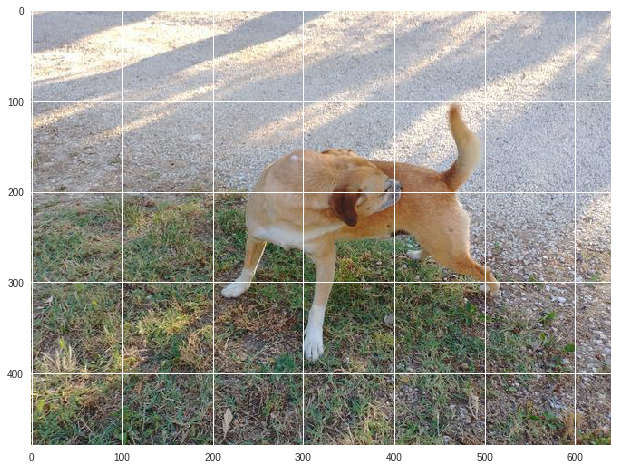

In [14]:
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ > '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/../datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/../datalab', 'label_map.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



from glob import glob
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

TEST_IMAGE_PATHS = glob('/root/../datalab/images/*.jpg')[:1]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  